# Exercise 4.7

## Original example

Parameters

In [1]:
# lambdas for expected number of requests and returns for each location respectively
LAM_REQ = (3, 4)
LAM_RET = (3, 2)

MAX_CARS = 20
MOVE_LIMIT = 5
SELL_PRICE = 10
MOVE_COST = 2
GAMMA = 0.9

State and action spaces

In [2]:
import itertools

def states():
    return itertools.product(range(MAX_CARS+1), range(MAX_CARS+1))

def actions(state):
    x, y = state
    # one can move at most the minimum between the remaining cars in the source, the remaining 
    # capacity of the destination and the limit of cars than can be moved in one night
    return range(max(-y, x-MAX_CARS, -MOVE_LIMIT), min(x, MAX_CARS-y, MOVE_LIMIT) + 1)

_Poisson_ probabilities for $Poisson(X = n, \lambda)$ and $Poisson(X \ge n, \lambda)$

In [3]:
import math
# from scipy.stats import poisson

poisson, poisson_ge = dict(), dict()

for n in range(21):
    for lam in LAM_REQ + LAM_RET:
        poisson[n, lam] = math.exp(-lam) * pow(lam, n) / math.factorial(n)
        poisson_ge[n, lam] = 1 - sum(poisson[m, lam] for m in range(n))

print("poisson(X = 0, 3):", poisson[0, 3])
print("poisson(X = 1, 3):", poisson[1, 3])
print("poisson(X >= 2, 3):", poisson_ge[2, 3])

poisson(X = 0, 3): 0.049787068367863944
poisson(X = 1, 3): 0.14936120510359183
poisson(X >= 2, 3): 0.8008517265285442


Expected rewards $r(s, a)$ and transition probabilities $p(s'| s, a)$ for $s\in\mathcal{S}$, $a\in\mathcal{A}(s)$ and $s'\in\mathcal{S}$

In [4]:
from operator import add, sub
from collections import defaultdict
from tqdm import tqdm_notebook

# Default probability for state-action-state transitions is zero
p = defaultdict(lambda: 0)
r = dict()

# Add tuples elementwise
def add_t(a, b):
    return tuple(map(add, a, b))

# Subtract tuples elementwise
def sub_t(a, b):
    return tuple(map(sub, a, b))

# One can only sell up to the number of cars at each store
def sales(s):
    return itertools.product(range(s[0] + 1), range(s[1] + 1))

# One can only receive up to the remaining capacity at each store
def returns(s):
    return itertools.product(range(MAX_CARS - s[0] + 1), range(MAX_CARS - s[1] + 1))

# Note: the probability of selling the remaining cars is the probability of receiving a number 
# of requests greater than or equal to the number of remaining cars
def prob_req(c, s):
    rem = sub_t(s, c)
    return (poisson[c[0], LAM_REQ[0]] if rem[0] > 0 else poisson_ge[c[0], LAM_REQ[0]]) * \
        (poisson[c[1], LAM_REQ[1]] if rem[1] > 0 else poisson_ge[c[1], LAM_REQ[1]])

# Note: the probability of reaching capacity after returns is the probability of receiving a 
# number of cars greater than or equal to the remaining capacity
def prob_ret(d, s):
    res = add_t(s, d)
    return (poisson[d[0], LAM_RET[0]] if res[0] < MAX_CARS else poisson_ge[d[0], LAM_RET[0]]) * \
        (poisson[d[1], LAM_RET[1]] if res[1] < MAX_CARS else poisson_ge[d[1], LAM_RET[1]])

    

for s in tqdm_notebook(states(), total=441, desc="Calculating", unit="states"):
    for a in actions(s):
        r[s, a] = - abs(a) * MOVE_COST
        s_a = add_t(s, (-a, a))
        for c in sales(s_a):
            prob_c = prob_req(c, s_a)
            r[s, a] += prob_c * sum(c) * SELL_PRICE
                  
            s_c = sub_t(s_a, c)
            for d in returns(s_c):
                prob_d = prob_ret(d, s_c)
                p[add_t(s_c, d), s, a] += prob_c * prob_d

_Bellman expectation equation_ for $v_\pi$ as a function of $r(s, a)$ and $p(s'| s, a)$.

In [5]:
def bellman_expectation(s, a, value):
    return r[s, a] + GAMMA * sum(p[s_d, s, a]*value[s_d] for s_d in states())

**Policy iteration algorithm**

In [6]:
import numpy as np

def policy_iteration(accuracy):
    # Initialization
    policy = np.zeros((MAX_CARS+1, MAX_CARS+1), dtype=np.int)
    value = np.zeros((MAX_CARS+1, MAX_CARS+1))
    for itr in itertools.count():
        print("Iteration:", itr)

        # Policy evaluation
        delta = float('inf')
        while delta >= accuracy:
            old_value = value.copy()
            for s in states():
                value[s] = bellman_expectation(s, policy[s], value)
            delta = np.sum(np.abs(value - old_value))
            print("Total error:", delta)

        # Policy improvement
        old_policy = policy.copy()
        for s in states():
            # Take the action that maximizes the bellman expectation equation
            policy[s] = max(actions(s), key=lambda a: bellman_expectation(s, a, value))

        actions_changed = np.sum(policy != old_policy)
        if actions_changed == 0:
            return policy, value
        print("Policy changed for {} states".format(actions_changed))

Results for example 4.2

In [7]:
%%time
policy, value = policy_iteration(1e-4)

Iteration: 0
Total error: 46085.486132039885
Total error: 37743.227662985555
Total error: 29508.97067255763
Total error: 23066.442824734273
Total error: 18263.508886811458
Total error: 14667.878668340598
Total error: 11912.525675943529
Total error: 9746.263066255891
Total error: 8008.113801685342
Total error: 6594.390242488254
Total error: 5435.253683780513
Total error: 4480.7910215377
Total error: 3693.320572034527
Total error: 3043.2045558052446
Total error: 2506.509478754744
Total error: 2063.6158698574322
Total error: 1698.3179531579576
Total error: 1397.1859769283164
Total error: 1149.080464945073
Total error: 944.763941930527
Total error: 776.5820916790672
Total error: 638.1985157376962
Total error: 524.3729680690147
Total error: 430.7757562808837
Total error: 353.83254977912594
Total error: 290.5948274624042
Total error: 238.6319304605385
Total error: 195.9412809261063
Total error: 160.87383523306738
Total error: 132.072279568645
Total error: 108.4198576909397
Total error: 88.99

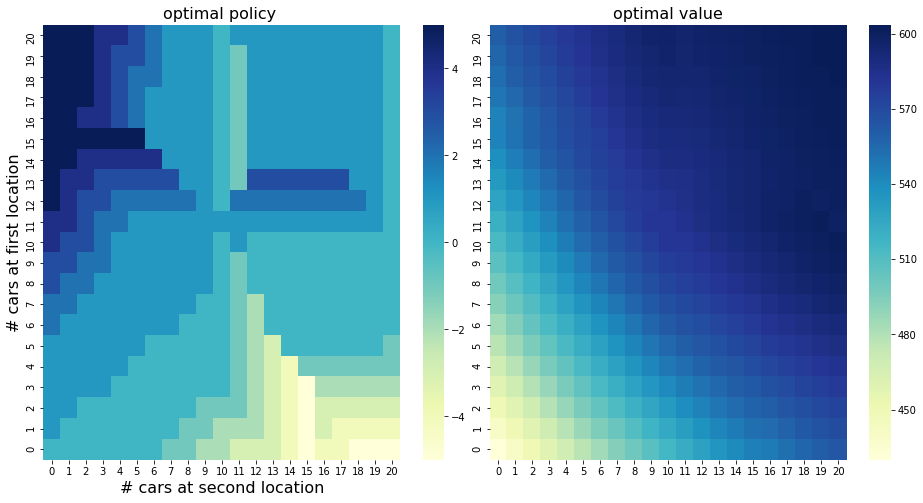

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plot_final_policy_value(policy, value):
    _, axes = plt.subplots(1, 2, figsize=(16, 8))
    plt.subplots_adjust(wspace=0, hspace=0.2)
    axes = axes.flatten()

    fig = sns.heatmap(
        np.flipud(policy), cmap="YlGnBu", ax=axes[0], yticklabels=list(reversed(range(MAX_CARS + 1))))
    fig.set_ylabel('# cars at first location', fontsize=16)
    fig.set_xlabel('# cars at second location', fontsize=16)
    fig.set_title('optimal policy ', fontsize=16)

    fig = sns.heatmap(
        np.flipud(value), cmap="YlGnBu", ax=axes[-1], yticklabels=list(reversed(range(MAX_CARS + 1))))
    fig.set_title('optimal value', fontsize=16)

    plt.show()
    
plot_final_policy_value(policy, value)

## Exercise 4.7 modifications

Note that the transition probabilities $p(s'| s, a)$ are not afected, therefore one only needs to recompute the expected rewards $r(s, a)$

In [9]:
PARK_SPACE = 10
PARK_FEE = 4

# Reset expected rewards
r.clear()
for s in tqdm_notebook(states(), total=441, desc="Calculating", unit="states"):
    for a in actions(s):
        # Can move one car for free from the first to the second location
        r[s, a] = - abs(a-1 if a > 0 else a) * MOVE_COST
        s_a = add_t(s, (-a, a))
        # Pay extra parking for each location that had its parking space exceeded
        r[s, a] -= PARK_FEE * sum(n > PARK_SPACE for n in s_a)
        for c in sales(s_a):
            prob_c = prob_req(c, s_a)
            r[s, a] += prob_c * sum(c) * SELL_PRICE

Results for exercise 4.7

In [10]:
%%time
policy, value = policy_iteration(1e-4)

Iteration: 0
Total error: 43438.550372382764
Total error: 35859.5230619084
Total error: 28176.524443355556
Total error: 22077.73290899717
Total error: 17490.676804069313
Total error: 14041.376468407376
Total error: 11394.226827308212
Total error: 9313.358893886423
Total error: 7645.2695888465205
Total error: 6290.166260043732
Total error: 5180.482358505138
Total error: 4267.823286565513
Total error: 3515.6541922274705
Total error: 2895.278138739847
Total error: 2383.567400150028
Total error: 1961.6039740610217
Total error: 1613.7941150750137
Total error: 1327.2399025774507
Total error: 1091.2611120550187
Total error: 897.014240062839
Total error: 737.1808748226422
Total error: 605.709465703177
Total error: 497.60019183528834
Total error: 408.72548299209535
Total error: 335.6803542476817
Total error: 275.6577599440659
Total error: 226.34494312314177
Total error: 185.8373764146665
Total error: 152.56741142748405
Total error: 125.24519946821658
Total error: 102.80982927682089
Total error:

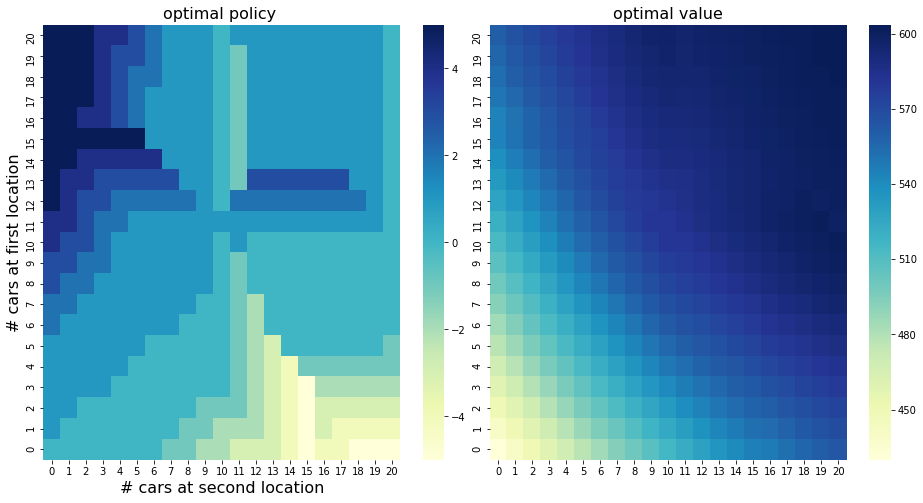

In [14]:
plot_final_policy_value(policy, value)